# 실습 1: 암흑물질 헤일로의 각종 질량으로부터 비리얼 반지름 예측하기

본 실습은 Horizon Run 5 시뮬레이션 중 특정 적색이동에서 나온 암흑물질 헤일로 목록에 대해 머신러닝 회귀 기법을 적용해 보는 것을 목표로 합니다.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

데이터를 읽어 봅시다.
데이터는 텍스트 형태로 되어 있는데, 어떤 형태로 되어 있는지 미리 파악하는 것이 좋습니다.
원래대로라면 데이터를 제공한 사람으로부터 데이터를 읽는 방법을 배워야 하지만, 다행히도 이 데이터는 맨 윗줄을 읽어 보면 어떤 형태인지 대충 알 수 있습니다.

In [2]:
# Jupyter notebook에서 느낌표(!) 다음에 커맨드 명령어를 직접 입력하여 실행할 수 있다.
!head halo_catalogue_296.txt

a= 0.615248018    H0= 68.4 km/s/Mpc    L=1048.58048 cMpc   Pure volume=  1.28216537e+07 cMpc^3
  ID         x (cMpc)    y (cMpc)    z (cMpc)   Vx (km/s)   Vy (km/s)   Vz (km/s)    Mtot (Msun)       Mdm (Msun)      Mstar (Msun)     Mgas (Msun)      Msmbh (Msun)     M200 (Msun)     R200 (cMpc)      Con_IDX  pure
0000000       0.380605   523.588555   494.607305   -244.3372    148.6069    408.3415   1.60595222e+09   1.58555095e+09   0.00000000e+00   2.04012707e+07   0.00000000e+00   5.53584536e+08   2.22889179e-02    0.129506   1
0000001       0.496440   523.428480   499.327201   -119.4390    275.9627    493.4503   1.70764954e+11   1.52695450e+11   1.94236511e+09   1.61271167e+10   2.19347816e+04   1.64814319e+11   1.48750598e-01    0.354509   1
0000002       0.439013   516.712034   522.460587   -251.5591     98.3662    290.8767   2.00156037e+09   1.99917294e+09   0.00000000e+00   2.38742881e+06   0.00000000e+00   1.25186727e+09   2.92478609e-02    0.110969   1
0000003       0.425976   519

In [3]:
rawData = np.genfromtxt('halo_catalogue_296.txt',skip_header=2)
arrMtot,arrMdm,arrMstar,arrMgas,arrM200,arrR200 = rawData[::100,7],rawData[::100,8],rawData[::100,9],rawData[::100,10],rawData[::100,12],rawData[::100,13]

$R_{200}$은 비리얼 반지름에 해당합니다. 이 값을 무엇으로 예측하면 가장 잘 나올까요?

<Figure size 432x288 with 0 Axes>

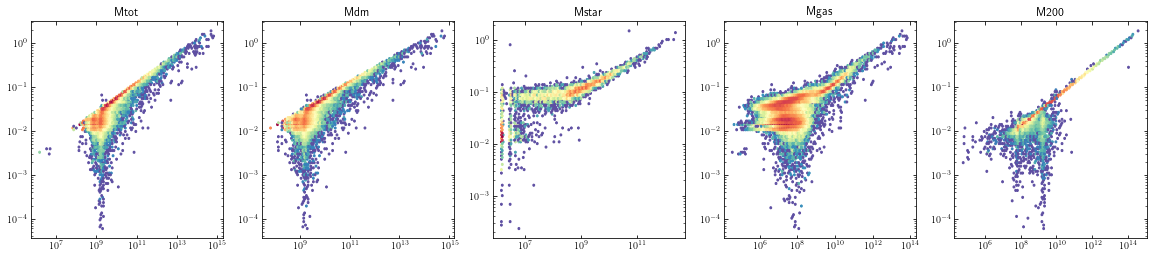

In [32]:
plt.clf()
fig,axs = plt.subplots(1,5,figsize=(20,4))
for ax,label,arr in zip(axs,["Mtot","Mdm","Mstar","Mgas","M200"],[arrMtot,arrMdm,arrMstar,arrMgas,arrM200]):
    indxGood = (arr > 0) & (arrR200 > 0)
    ax.hexbin(arr[indxGood],arrR200[indxGood],xscale='log',yscale='log',bins='log',mincnt=1,cmap='Spectral_r',rasterized=True)
    ax.set_title(label)

In [33]:
indxGood = (arrM200 > 0) & (arrR200 > 0)
arrM200Good,arrR200Good = arrM200[indxGood],arrR200[indxGood]

In [34]:
Ntrain = len(arrM200Good)*4//5
X_train,Y_train,X_test,Y_test = arrM200Good[:Ntrain],arrR200Good[:Ntrain],arrM200Good[Ntrain:],arrR200Good[Ntrain:]

In [35]:
names = ["Nearest Neighbors",
         #"Linear SVM",
         #"Gaussian Process",
         "Decision Tree",
         "Random Forest"]

regressors = [
    KNeighborsRegressor(3),
    #SVR(kernel="linear", C=0.025),
    #GaussianProcessRegressor(1.0 * RBF(1.0)),
    DecisionTreeRegressor(max_depth=5),
    RandomForestRegressor(max_depth=5, n_estimators=10, max_features=1)]

Nreg = len(regressors)

Done:  Nearest Neighbors
Done:  Decision Tree
Done:  Random Forest


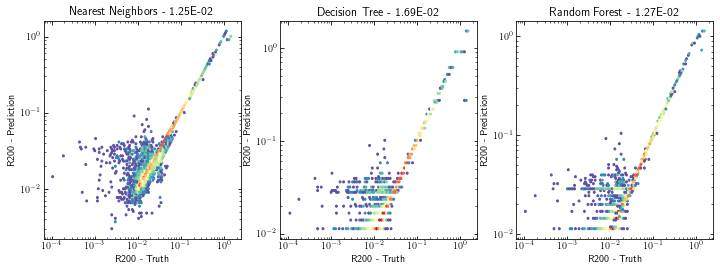

In [37]:
fig,axs = plt.subplots(1,Nreg,figsize=(Nreg*4,4))
for ax,name,reg in zip(axs,names,regressors):
    reg.fit(X_train.reshape(-1,1),Y_train)
    Y_pred = reg.predict(X_test.reshape(-1,1))
    score = np.average((Y_pred-Y_test)**2)**0.5
    ax.hexbin(Y_test,Y_pred,xscale='log',yscale='log',bins='log',mincnt=1,cmap='Spectral_r',rasterized=True)
    ax.set_title('{} - {:.2E}'.format(name,score))
    ax.set_xlabel('R200 - Truth')
    ax.set_ylabel('R200 - Prediction')
    print('Done: ',name)

다른 방법으로 개선해 볼 수 있을까요? 입력 파라메터의 종류를 늘리는 건 어떨까요?

In [38]:
arrMtotGood = arrMtot[indxGood]
X_train,X_test = np.vstack([arrMtotGood[:Ntrain],arrM200Good[:Ntrain]]).T,np.vstack([arrMtotGood[Ntrain:],arrM200Good[Ntrain:]]).T

Done:  Nearest Neighbors
Done:  Decision Tree
Done:  Random Forest


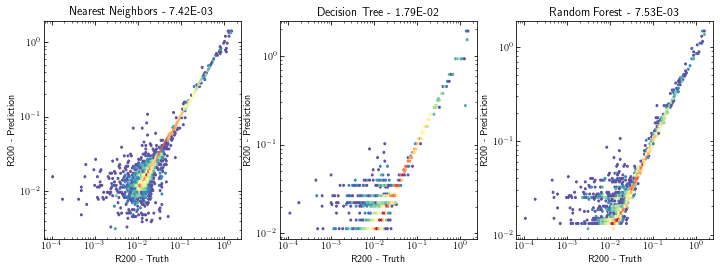

In [39]:
fig,axs = plt.subplots(1,Nreg,figsize=(Nreg*4,4))
for ax,name,reg in zip(axs,names,regressors):
    reg.fit(X_train,Y_train)
    Y_pred = reg.predict(X_test)
    score = np.average((Y_pred-Y_test)**2)**0.5
    ax.hexbin(Y_test,Y_pred,xscale='log',yscale='log',bins='log',mincnt=1,cmap='Spectral_r',rasterized=True)
    ax.set_title('{} - {:.2E}'.format(name,score))
    ax.set_xlabel('R200 - Truth')
    ax.set_ylabel('R200 - Prediction')
    print('Done: ',name)

아니면 입/출력값에 모두 로그를 씌워 볼까요?

In [40]:
X_train,Y_train,X_test,Y_test = arrM200Good[:Ntrain],arrR200Good[:Ntrain],arrM200Good[Ntrain:],arrR200Good[Ntrain:]

Done:  Nearest Neighbors
Done:  Decision Tree
Done:  Random Forest


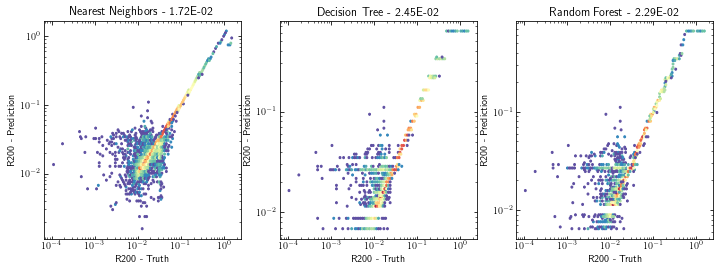

In [41]:
fig,axs = plt.subplots(1,Nreg,figsize=(Nreg*4,4))
for ax,name,reg in zip(axs,names,regressors):
    reg.fit(np.log10(X_train).reshape(-1,1),np.log10(Y_train))
    Y_pred = 10.**(reg.predict(np.log10(X_test).reshape(-1,1)))
    score = np.average((Y_pred-Y_test)**2)**0.5
    ax.hexbin(Y_test,Y_pred,xscale='log',yscale='log',bins='log',mincnt=1,cmap='Spectral_r',rasterized=True)
    ax.set_title('{} - {:.2E}'.format(name,score))
    ax.set_xlabel('R200 - Truth')
    ax.set_ylabel('R200 - Prediction')
    print('Done: ',name)